In [ ]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz
!pip install shapely

In [3]:
import pandas as pd
import numpy as np
import importlib
from datetime import datetime
from datetime import timedelta
import time
import copy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import math
import IPython
import os

In [4]:
base_lat = [32, 36]
base_lon = [125, 129]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 25
pivot_time = 5
gridmap_pivot_distance_km = 5

In [5]:
TRAINING_DIR = 'training_data/'
TRAINING_CSV_LIST = ['Dynamic_20200204_13_0_0.csv',
                     'Dynamic_20200204_14_0_0.csv',
                     'Dynamic_20200204_15_0_0.csv',
                     'Dynamic_20200204_16_0_0.csv',
                     'Dynamic_20200204_17_0_0.csv']
data_set = pd.DataFrame()

In [6]:
for csv in TRAINING_CSV_LIST:
    file = TRAINING_DIR + csv
    print('Read file:%s'%file)
    if os.path.exists(file):
        tdf = pd.read_csv(file)
        data_set = pd.concat([data_set, tdf])
    else:
        print('%s is not exist.'%file)

Read file:training_data/Dynamic_20200204_13_0_0.csv
Read file:training_data/Dynamic_20200204_14_0_0.csv
Read file:training_data/Dynamic_20200204_15_0_0.csv
Read file:training_data/Dynamic_20200204_16_0_0.csv
Read file:training_data/Dynamic_20200204_17_0_0.csv


In [7]:
data_set = data_set.sample(frac=1).reset_index(drop=True)

In [8]:
data_set

,Measurement_time,Predict_time_time,N_of_ships,Grid1_N_of_ships,Grid1_pos_weight,Grid1_avg_SOG,Grid2_N_of_ships,Grid2_pos_weight,Grid2_avg_SOG,Grid3_N_of_ships,...,Grid86_avg_SOG,Grid87_N_of_ships,Grid87_pos_weight,Grid87_avg_SOG,Grid88_N_of_ships,Grid88_pos_weight,Grid88_avg_SOG,Grid89_N_of_ships,Grid89_pos_weight,Grid89_avg_SOG
0,2020-02-04 14:00:00,2020-02-04 15:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
1,2020-02-04 17:00:00,2020-02-04 18:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,10.157143,24.0,7.0,0.0,28.0,0.0,9.6,0.0,2.0
2,2020-02-04 16:00:00,2020-02-04 17:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.800000,13.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0
3,2020-02-04 14:00:00,2020-02-04 15:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-04 14:00:00,2020-02-04 15:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35875,2020-02-04 13:00:00,2020-02-04 14:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35876,2020-02-04 17:00:00,2020-02-04 18:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35877,2020-02-04 14:00:00,2020-02-04 15:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,11.0,0.0,0.0,23.0,0.0,1.7,0.0,1.0
35878,2020-02-04 14:00:00,2020-02-04 15:00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 우선 선박의 수로 예측을 진행하기로 함.

In [9]:
nmin = min(data_set['N_of_ships'].values)
nmax = max(data_set['N_of_ships'].values)

print('min of N : %d'%nmin)
print('max of N : %d'%nmax)

min of N : 0
max of N : 73


In [10]:
# space_itv = [0, 1, 2, 3, 5, 8, 13, 21, 34]
space_itv = [0, 5, 10, 15, 20, 30, 40, 50]
space = []

for i in range(0, len(space_itv)-1):
    tspace = [x for x in data_set['N_of_ships'].values if x >= space_itv[i] and x < space_itv[i+1]]
    space.append(tspace)
space.append([x for x in data_set['N_of_ships'].values if x >= space_itv[len(space_itv)-1]])

In [11]:
for s in space:
    print(len(s))

35240
387
88
61
54
23
14
13


In [12]:
### training에 사용되는 column들 ###
label = copy.deepcopy(data_set['N_of_ships'].values)
cols = list(data_set)[3:]
column_set = data_set[cols].astype(float)

In [13]:
label

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
column_set

,Grid1_N_of_ships,Grid1_pos_weight,Grid1_avg_SOG,Grid2_N_of_ships,Grid2_pos_weight,Grid2_avg_SOG,Grid3_N_of_ships,Grid3_pos_weight,Grid3_avg_SOG,Grid4_N_of_ships,...,Grid86_avg_SOG,Grid87_N_of_ships,Grid87_pos_weight,Grid87_avg_SOG,Grid88_N_of_ships,Grid88_pos_weight,Grid88_avg_SOG,Grid89_N_of_ships,Grid89_pos_weight,Grid89_avg_SOG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,10.157143,24.0,7.0,0.0,28.0,0.0,9.6,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.800000,13.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,11.0,0.0,0.0,23.0,0.0,1.7,0.0,1.0
35878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
### 변수들의 scale이 너무 다른 경우를 대비하여, scaling을 진행해준다 ###
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(column_set)
data_set_scaled = scaler.transform(column_set)
data_set_scaled

array([[-0.05902755, -0.12356861, -0.0481361 , ..., -0.32574262,
         0.        , -0.21875989],
       [-0.05902755, -0.12356861, -0.0481361 , ...,  2.77277148,
         0.        ,  0.6164734 ],
       [-0.05902755, -0.12356861, -0.0481361 , ..., -0.32574262,
         0.        , -0.21875989],
       ...,
       [-0.05902755, -0.12356861, -0.0481361 , ...,  0.22295259,
         0.        ,  0.19885675],
       [-0.05902755, -0.12356861, -0.0481361 , ..., -0.32574262,
         0.        , -0.21875989],
       [-0.05902755, -0.12356861, -0.0481361 , ..., -0.32574262,
         0.        , -0.21875989]])

In [16]:
# split to train data and test data
n_train = int(0.9*data_set_scaled.shape[0]) # 트레이닝 데이터와 테스트 데이터의 수를 9:1 비율로 분할. 
train_data_scaled = data_set_scaled[0: n_train] 
train_dates = column_set[0: n_train]

test_data_scaled = data_set_scaled[n_train:]
test_dates = column_set[n_train:]
# print(test_dates.head(5))

In [17]:
# label값 설정
for i in range(0, len(label)):
    newv = 0
    for space in space_itv[1:]:
        if label[i] < space:
            break
        newv += 1
    label[i] = newv

In [18]:
nmin = min(label)
nmax = max(label)

print('min of N : %d'%nmin)
print('max of N : %d'%nmax)

min of N : 0
max of N : 7


In [19]:
print('Shape of train set:' + str(train_dates.shape))
print('Shape of test set:' + str(test_dates.shape))

Shape of train set:(32292, 267)
Shape of test set:(3588, 267)


In [20]:
# 하이퍼파라미터들
# data reformatting for LSTM
input_dim = 3  # input_dimension: training column 길이
# sequence length: 예측에 사용되는 data의 row길이. 이 경우에는 detected grid의 숫자로 train_dates.shape[1] / input_dim과 동일.
seq_len = int(train_dates.shape[1] / input_dim)

learning_rate = 0.01
epochs = 30
batch_size = 32
validation_split = 0.1
verbose = 1

In [21]:
trainX = []
trainY = []
testX = []
testY = []

In [22]:
for row in train_data_scaled:
    grid_info = [row[i*input_dim:(i+1)*input_dim] for i in range(0, int(len(row)/input_dim))]
    trainX.append(grid_info)
for row in test_data_scaled:
    grid_info = [row[i*input_dim:(i+1)*input_dim] for i in range(0, int(len(row)/input_dim))]
    testX.append(grid_info)
trainY = [[x] for x in label[0:n_train]]
testY = [[x] for x in label[n_train:]]

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [23]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(32292, 89, 3) (32292, 1)
(3588, 89, 3) (3588, 1)


In [24]:
# LSTM model
# 가장 simple한 형태로, 추후 activation함수나 깊이 조정 필요.
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 89, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
909/909 [==============================] - 21s 21ms/step - loss: 0.0448 - val_loss: 0.0392
Epoch 2/30
909/909 [==============================] - 19s 21ms/step - loss: 0.0388 - val_loss: 0.0433
Epoch 3/30
909/909 [==============================] - 18s 20ms/step - loss: 0.0329 - val_loss: 0.0373
Epoch 4/30
909/909 [==============================] - 18s 20ms/step - loss: 0.0319 - val_loss: 0.0389
Epoch 5/30
909/909 [==============================] - 18s 20ms/step - loss: 0.0317 - val_loss: 0.0362
Epoch 6/30
909/909 [==============================] - 18s 20ms/step - loss: 0.0313 - val_loss: 0.0367
Epoch 7/30
909/909 [==============================] - 18s 20ms/step - loss: 0.0300 - val_loss: 0.0379
Epoch 8/30
909/909 [==============================] - 19s 21ms/step - loss: 0.0283 - val_loss: 0.0381
Epoch 9/30
909/909 [==============================] - 19s 20ms/step - loss: 0.0290 - val_loss: 0.0382
Epoch 10/30
909/909 [===============

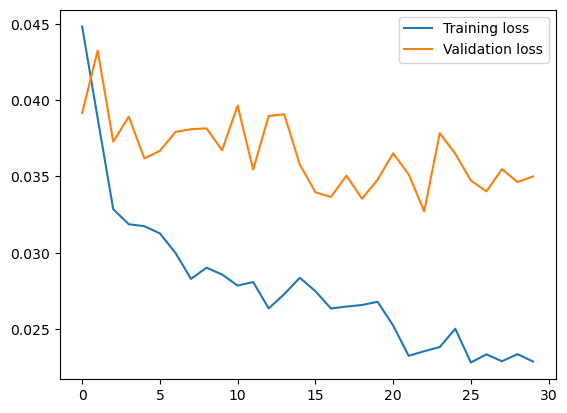

In [26]:
# Try to load weights
try:
    model.load_weights('./save_weights/lstm_weights_with_class.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,
                    validation_split=validation_split, verbose=verbose)
    # Save model weights after training
    model.save_weights('./save_weights/lstm_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [ ]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

In [ ]:
# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

In [ ]:
# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)


In [ ]:
# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

In [ ]:
# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

In [ ]:
# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

In [ ]:
# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)